# Predicting JP Morgan Stock Price

## Business Problem

I have been assigned the role of a data scientist working for an asset manager that is curious about the future stock price of one of their top holdings: JP Morgan(JPM). They are interested to see if Machine Learning can help assist them with investment decisions on behalf of their clients. 

## Disclaimer

This is by no means any form of investment advice. Predicting the price of a stock is an extremely difficult task to accomplish becuase if it wasn't, everyone would be rich. Based on the [Efficient-market Hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis) stock prices are a function of information and rational expectations. Changes in stock price reflect the release of new information, changes in market generally, or random movements. Stock prices are thus described as a "random walk" meaning each day's deviations from the central value are random and unpredicatble. Despite the difficulty we will try our best to predict JPM stock price based on many features.

In [1]:
#import necessary packages

#Utility
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import numpy as np
from sklearn.decomposition import PCA
import math

#Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

## The Data

It is important to understand what moves the price of JPM up or down. As stated prevously it is what people think. Therefore we need to incorporate as much information as possible that correlates to JPM. We will be using daily data starting from 2012 - 2021 (1584 training days -- 70% of the data and 680 test (hold-out) days -- 30% of the data. 

1.) Correlated Assets - these are assets( any type not necessarily stocks, such as commodities, FX, indices, or even fixed income securities). JPM lives in a world with other assets that it relies and depends on. Capturing these will be important.

2.) Technical Indicators- Thes are heuristic or pattern based signals that allow investors to analyze historical data and hopefully with some reliable estimate predict future prices. Included will be 7 and 21 day moving average, EMA (Exponential moving average), momentum, bollinger bands, MACD, etc.

3.)Fourier Transforms - We will generate several long and short term trends. Using these transforms will help us eliminate a lot of noise (random walks) and create approximations of real stock movement. 

4.) Autoregressive Moving Average(ARIMA) - This is popular technique in predicting future values of time series data. We will be using it as a feature so that our LSTM has the best possible inputs.

The Data for this will be coming from the Yahoo Finance API.

In [2]:
#define the ticker
tickerSymbol = 'JPM'

In [3]:
#make the API connection
tickerData = yf.Ticker(tickerSymbol)

In [4]:
#set the time period
tickerDf = tickerData.history(period = '1d', start = '2012-1-1', end = '2020-12-31')

In [5]:
df = pd.DataFrame(tickerDf)

In [6]:
#create a function for dates
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [7]:
df = df.to_csv(r'/Users/michaelrozenvasser/Capstone\JP_Morgan_Data.csv')

In [8]:
df = pd.read_csv('/Users/michaelrozenvasser/Capstone\JP_Morgan_Data.csv', header=0, parse_dates=[0], date_parser=parser)

In [9]:
df[['Date', 'Close']].head(3)

,Date,Close
0,2012-01-03,27.021782
1,2012-01-04,27.192959
2,2012-01-05,27.760937


#### Great we have our data. We will be using closing prices as they are better than opening or average prices.

In [10]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 2264 number of days in the dataset.


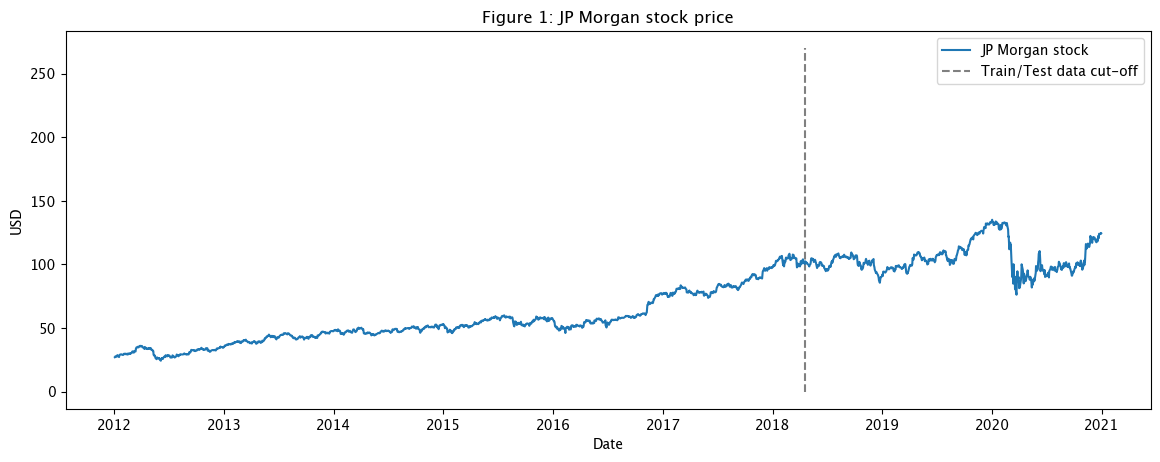

In [11]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='JP Morgan stock')
plt.vlines(datetime.date(2018,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: JP Morgan stock price')
plt.legend()
plt.show()

In [12]:
num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    df.shape[0]-num_training_days))

Number of training days: 1584. Number of test days: 680.


#### The data was divided from 2012 - 2018 and then from mid 2018  -  2021. JPM price really shot up after 2019 so I am going to normalize the training data so that a model can train in a way that it might expect the volatility.

# Feature Generation

In [13]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    df['ma7'] = df['Close'].rolling(7).mean()
    df['ma21'] = df['Close'].rolling(21).mean()
    
    #Create MACD
    df['26ema'] = df['Close'].ewm(span=26).mean()
    df['12ema'] = df['Close'].ewm(span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])
    
    #Create Bollinger Bands
    df['20sd'] = df['Close'].rolling(21).std()
    df['upper_band'] = (df['Close'].rolling(window = 20).mean()) + (df['20sd']*2)
    df['lower_band'] = (df['Close'].rolling(window = 20).mean()) - (df['20sd']*2)
    
    
    #Create Exponential moving average
    df['ema'] = df['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    df['momentum'] = (df['Close']/100)-1

    return df

##### List of technical indicators:

   #### 1.) Bollinger Bands: Consists of a centerline and two price channels(bands) above and below it. The center line is the exponential moving average. Bollinger Bands are a volatility indicator and will expand and contract as the price action becomes volatile or bound into a tight trading pattern.
   
   #### 2.) EMA: Exponential moving average. Just averages out the data so we know how a company was trending for a certain amount of days.
   
   #### 3.) Momentum: Rate of change in a price movement for a particualr asset. This is calcualted as Momentum = Latest price  - (Closing Price x # of Days)
   
   #### 4.) 7 and 21 day moving averages should be pretty self explanatory. 
   

[Trading with Technical analysis](https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861)
   

In [14]:
df_TI = get_technical_indicators(df['Close'])

In [15]:
df_TI.head(21)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2012-01-03,26.311090,27.184005,26.272463,27.021782,44102800,0.00,0,NaN,NaN,27.021782,27.021782,0.000000,NaN,NaN,NaN,27.021782,-0.729782
1,2012-01-04,26.796150,27.348570,26.710567,27.192959,36571200,0.25,0,NaN,NaN,27.110662,27.114503,0.003841,NaN,NaN,NaN,27.150165,-0.728070
2,2012-01-05,27.006224,27.947668,26.765030,27.760937,38381400,0.00,0,NaN,NaN,27.344300,27.366806,0.022507,NaN,NaN,NaN,27.573007,-0.722391
3,2012-01-06,27.768700,27.830945,27.340771,27.511944,33160600,0.00,0,NaN,NaN,27.391166,27.412620,0.021455,NaN,NaN,NaN,27.531789,-0.724881
4,2012-01-09,27.574200,27.760934,27.224078,27.465273,23001800,0.00,0,NaN,NaN,27.408351,27.426926,0.018575,NaN,NaN,NaN,27.487262,-0.725347
5,2012-01-10,28.064365,28.282219,27.823167,28.048803,35972800,0.00,0,NaN,NaN,27.536629,27.578075,0.041446,NaN,NaN,NaN,27.862137,-0.719512
6,2012-01-11,27.854296,28.585668,27.745369,28.523422,29852900,0.00,0,27.646446,NaN,27.712125,27.789026,0.076901,NaN,NaN,NaN,28.303196,-0.714766
7,2012-01-12,28.647920,28.826872,28.142184,28.671261,39420700,0.00,0,27.882086,NaN,27.866665,27.973135,0.106469,NaN,NaN,NaN,28.548610,-0.713287
8,2012-01-13,27.434147,27.947662,27.333003,27.947662,61571500,0.00,0,27.989900,NaN,27.878671,27.968095,0.089424,NaN,NaN,NaN,28.147958,-0.720523
9,2012-01-17,27.115139,27.760924,26.842822,27.161823,55115100,0.00,0,27.904313,NaN,27.779753,27.815307,0.035554,NaN,NaN,NaN,27.490524,-0.728382


#### We are checking 21 rows to see if everything worked and it did.

In [16]:
def plot_technical_indicators(df_TI, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = df_TI.shape[0]
    xmacd_ = shape_0-last_days
    
    df_TI = df_TI.iloc[-last_days:, :]
    x_ = range(3, df_TI.shape[0])
    x_ =list(df_TI.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(df_TI['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(df_TI['Close'],label='Closing Price', color='b')
    plt.plot(df_TI['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(df_TI['upper_band'],label='Upper Band', color='c')
    plt.plot(df_TI['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, df_TI['lower_band'], df_TI['upper_band'], alpha=0.35)
    plt.title('Technical indicators for JP Morgan - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(df_TI['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(df_TI['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

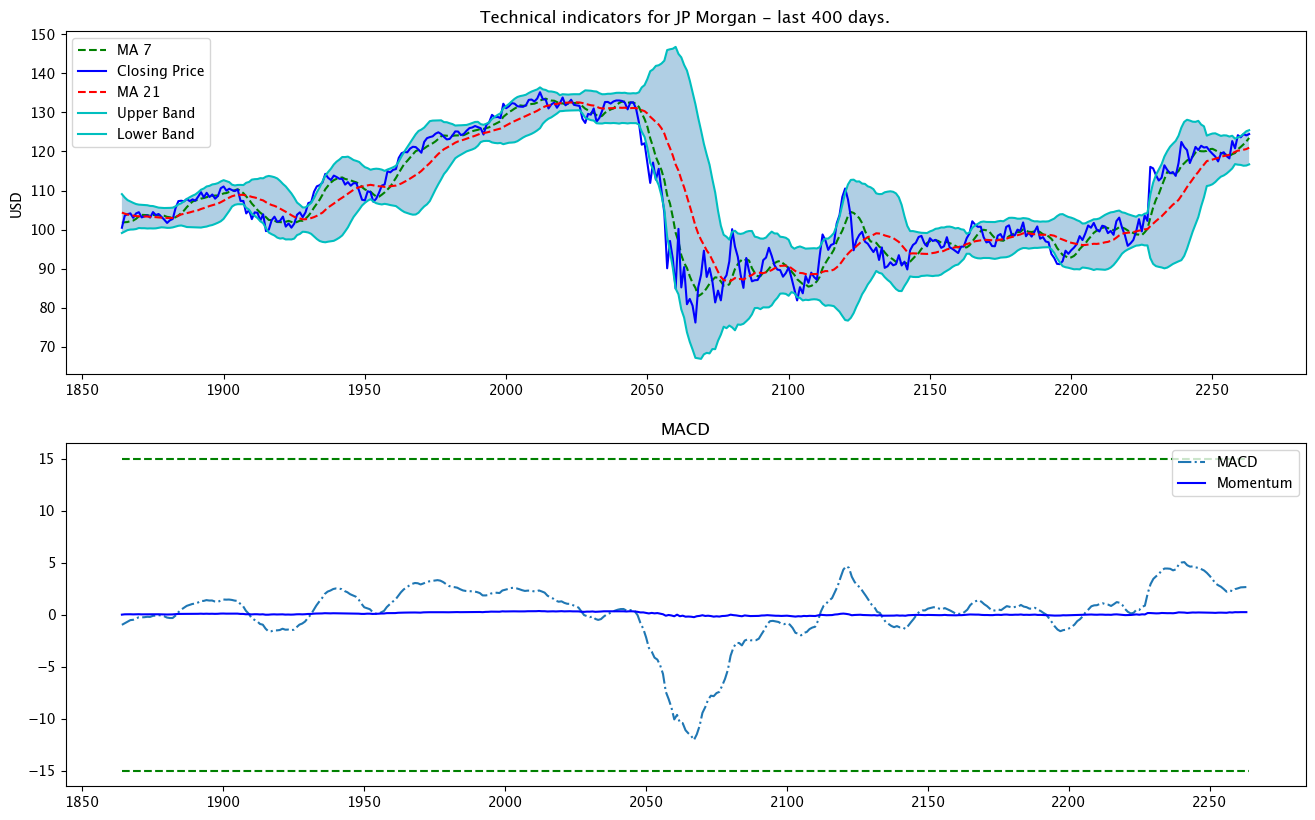

In [17]:
plot_technical_indicators(df_TI, 400)

#### The first plot is showing how our technical indicators are moving on a for a few of our last days. 

#### The second plot is showing the threshold between MACD and Momentum. As we can see momentum is giving an average value of the MACD in between the peak values and the highest or lowest values

# Fourier Transforms

In [18]:
data_FT = df_TI[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


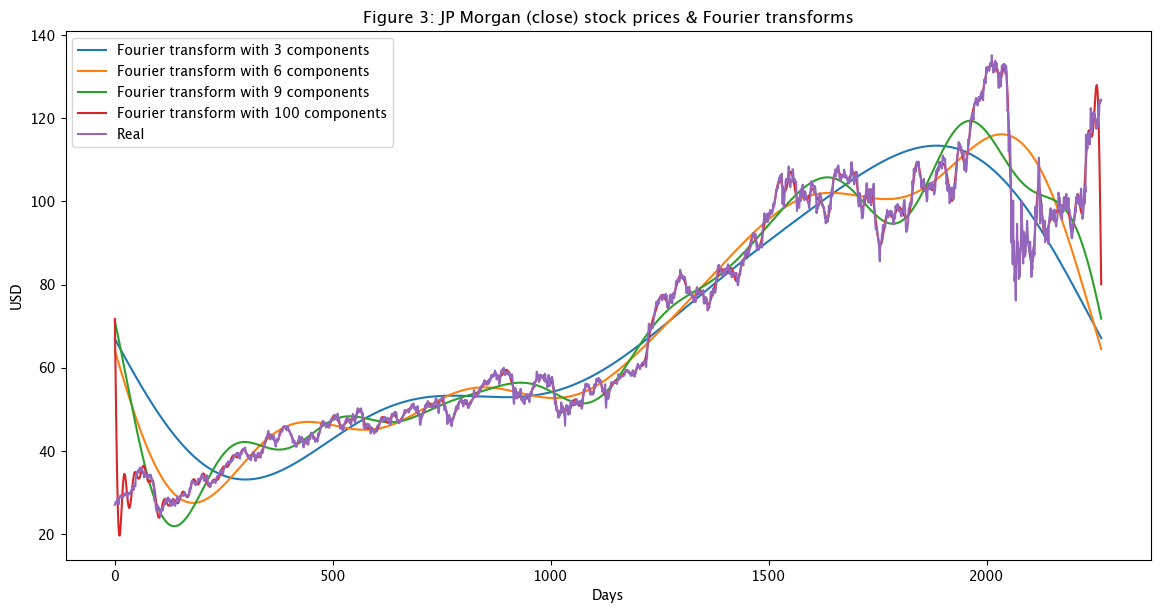

In [19]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: JP Morgan (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


#### Fourier Transforms uses many spectral components to try and train the data. It helps us extract a cycle from a series of data.

https://www.metastock.com/customer/resources/taaz/?p=58

In [20]:
def get_fourier(df):
    data_FT = df[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    df['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #df['absolute'] = df['Fourier'].apply(lambda x: np.abs(x))
    return df

#### The 100th component gives us the best result so we are moving forward with that.

In [21]:
df_TI = get_fourier(df)

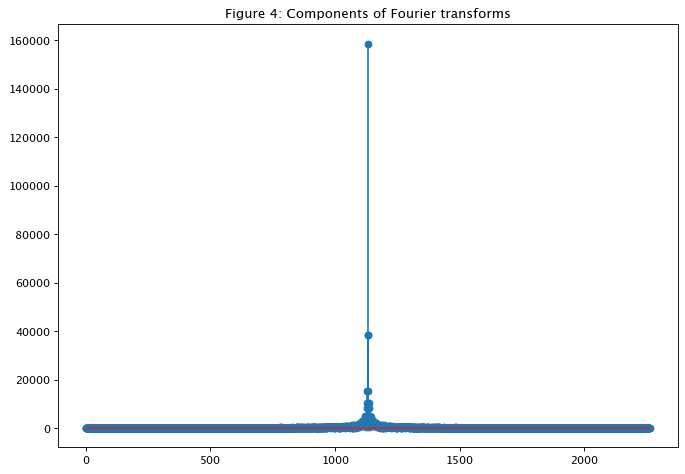

In [22]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

#### Component analysis of Fourier Transforms once the spectral part of the Fourier trasnform is removed the magnitude part is quite close to the test series. Our frourier trasnform is working.

# ARIMA AS A FEATURE

In [23]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

<ipython-input-23-a3a78b1cbd35>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Fu

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2263
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3885.185
Method:                       css-mle   S.D. of innovations              1.347
Date:                Thu, 18 Feb 2021   AIC                           7784.370
Time:                        01:18:22   BIC                           7824.441
Sample:                             1   HQIC                          7798.991
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0431      0.026      1.655      0.098      -0.008       0.094
ar.L1.D.Close    -0.1263      0.021     -6.024      0.000      -0.167      -0.085
ar.L2.D.Close     0.1052      0.021     

#### We see that soem of our P-values are greater than 0.05, so that is good enough for our model.

#### Also, the difference between AIC and BIC is low so that is an indication of a good model.

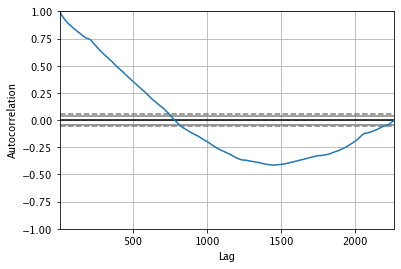

<Figure size 800x560 with 0 Axes>

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

#### From running an autocorrelation plot we see there is a positive correlation between the first 0 to 700 lags.

In [25]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

df_TI['ARIMA'] = pd.DataFrame(predictions)

<ipython-input-25-15bab93da036>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/Users/michaelrozenvasser/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Fu

#### ARIMA Code reference:
https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56

In [26]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 4.669


In [42]:
df_TI.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA
0,2012-01-03,26.311090,27.184005,26.272463,27.021782,44102800,0.00,0,NaN,NaN,27.021782,27.021782,0.000000,NaN,NaN,NaN,27.021782,-0.729782,27.021782,94.930504
1,2012-01-04,26.796150,27.348570,26.710567,27.192959,36571200,0.25,0,NaN,NaN,27.110662,27.114503,0.003841,NaN,NaN,NaN,27.150165,-0.728070,27.192959,96.273330
2,2012-01-05,27.006224,27.947668,26.765030,27.760937,38381400,0.00,0,NaN,NaN,27.344300,27.366806,0.022507,NaN,NaN,NaN,27.573007,-0.722391,27.760937,96.023913
3,2012-01-06,27.768700,27.830945,27.340771,27.511944,33160600,0.00,0,NaN,NaN,27.391166,27.412620,0.021455,NaN,NaN,NaN,27.531789,-0.724881,27.511944,97.164609
4,2012-01-09,27.574200,27.760934,27.224078,27.465273,23001800,0.00,0,NaN,NaN,27.408351,27.426926,0.018575,NaN,NaN,NaN,27.487262,-0.725347,27.465273,95.806348


#### Our MSE is very good lets see how our model is fit.

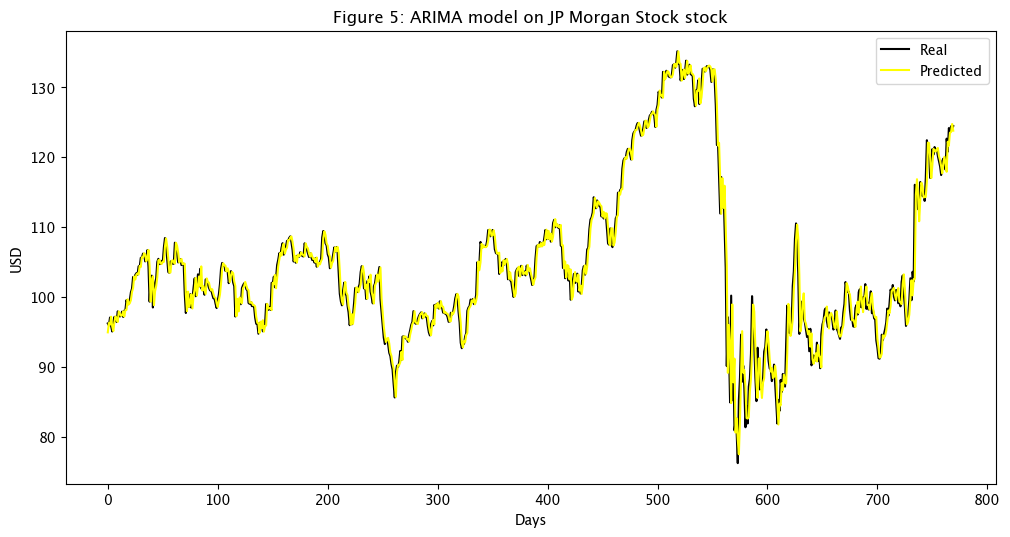

In [27]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on JP Morgan Stock stock')
plt.legend()
plt.show()

#### As we can see ARIMA gives us a very good prediction of the true stock price. IT will be great to add as a feature.

# Finding Importance of Features Using XGBOOST

#### Since we have a total of 19 features it is important to decipher which ones are actually important to the movement of JPM price. WE will be using XGBoost for this purpose.

In [28]:
def get_feature_importance_data(df_TI):
    data = df_TI.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [29]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df_TI)

In [30]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [31]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [32]:
eval_result = regressor.evals_result()

In [33]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

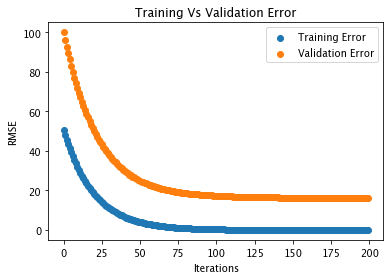

In [34]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#### There is a difference between validation and training error which may be indicative of an underfit model. This may be due to the how the data was split up as JPM price increased greatly during the test data portion.

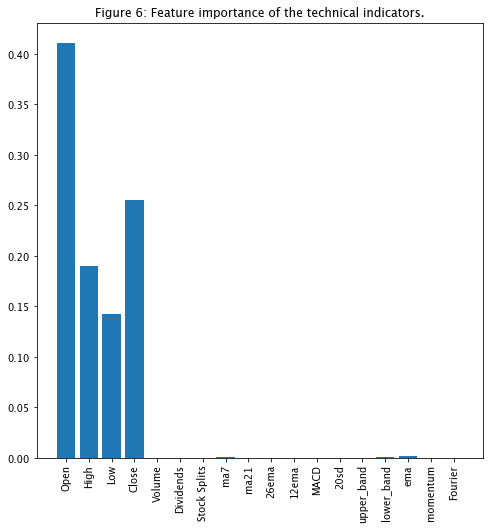

In [35]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

#### ma7, lower_band, ema and ma21 are among some of our most important features. Open prices should be close to close prices so if EMA doesnt work we will average open and close prices.

#### I would of loved for Fourier and ARIMA to be important but because of the spectral component of Fourier and because ARIMA doesn't produce any other features I wont consider them.

In [43]:
dataset_lstm_df = df_TI.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA
0,26.311090,27.184005,26.272463,27.021782,44102800,0.00,0,NaN,NaN,27.021782,27.021782,0.000000,NaN,NaN,NaN,27.021782,-0.729782,27.021782,94.930504
1,26.796150,27.348570,26.710567,27.192959,36571200,0.25,0,NaN,NaN,27.110662,27.114503,0.003841,NaN,NaN,NaN,27.150165,-0.728070,27.192959,96.273330
2,27.006224,27.947668,26.765030,27.760937,38381400,0.00,0,NaN,NaN,27.344300,27.366806,0.022507,NaN,NaN,NaN,27.573007,-0.722391,27.760937,96.023913
3,27.768700,27.830945,27.340771,27.511944,33160600,0.00,0,NaN,NaN,27.391166,27.412620,0.021455,NaN,NaN,NaN,27.531789,-0.724881,27.511944,97.164609
4,27.574200,27.760934,27.224078,27.465273,23001800,0.00,0,NaN,NaN,27.408351,27.426926,0.018575,NaN,NaN,NaN,27.487262,-0.725347,27.465273,95.806348
5,28.064365,28.282219,27.823167,28.048803,35972800,0.00,0,NaN,NaN,27.536629,27.578075,0.041446,NaN,NaN,NaN,27.862137,-0.719512,28.048803,95.104860
6,27.854296,28.585668,27.745369,28.523422,29852900,0.00,0,27.646446,NaN,27.712125,27.789026,0.076901,NaN,NaN,NaN,28.303196,-0.714766,28.523422,96.390379


In [38]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 2264 samples, and 19 features.


# LSTM

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [74]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

In [75]:
open_training = train.iloc[:, 1:2].values

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])
    

#### Normalize the data: The data is not normalized and the range for each column varies. Normalizing helps the algorihm find the local/global minimum.

#### Our window is 2200. So we will use 70 to 500.

Code for reference: https://github.com/LiamConnell/deep-algotrading

In [77]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

#### Convert our feature set into a 3D input so LSTM can run

In [78]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))

Epoch 1/100
13/13 [==============================] - 3s 85ms/step - loss: 0.1328 - mean_absolute_error: 0.2963 - val_loss: 0.0798 - val_mean_absolute_error: 0.2293
Epoch 2/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0688 - mean_absolute_error: 0.2226 - val_loss: 0.0684 - val_mean_absolute_error: 0.2360
Epoch 3/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0693 - mean_absolute_error: 0.2317 - val_loss: 0.0712 - val_mean_absolute_error: 0.2419
Epoch 4/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0690 - mean_absolute_error: 0.2380 - val_loss: 0.0686 - val_mean_absolute_error: 0.2346
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0688 - mean_absolute_error: 0.2376 - val_loss: 0.0691 - val_mean_absolute_error: 0.2393
Epoch 6/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0710 - mean_absolute_error: 0.2419 - val_loss: 0.0720 - val_mean_absolute_error: 0.2306
Epoch 7/100
13/1

Epoch 51/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0677 - mean_absolute_error: 0.2326 - val_loss: 0.0648 - val_mean_absolute_error: 0.2284
Epoch 52/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0630 - mean_absolute_error: 0.2270 - val_loss: 0.0655 - val_mean_absolute_error: 0.2263
Epoch 53/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0640 - mean_absolute_error: 0.2264 - val_loss: 0.0651 - val_mean_absolute_error: 0.2308
Epoch 54/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0642 - mean_absolute_error: 0.2282 - val_loss: 0.0681 - val_mean_absolute_error: 0.2228
Epoch 55/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0625 - mean_absolute_error: 0.2208 - val_loss: 0.0644 - val_mean_absolute_error: 0.2280
Epoch 56/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0676 - mean_absolute_error: 0.2299 - val_loss: 0.0646 - val_mean_absolute_error: 0.2288
Epoch 57/1

#### MAE: the difference between the input and output for all 2264 datapoints is 0.2167. The value is however for days so it is pretty bad. 

#### The data is trained for 100 epochs and optimizer is adam and loss is mse. This seems to be an ok model bcause our mean absolute error is 0.21 and val mean absolute error is 0.21as well so it is indicating that it is overfitting.

In [79]:
#Test the model
open_testing_processed = test.iloc[:, 1:2].values

In [80]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

In [81]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [82]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [83]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [84]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [85]:
#make predictions
predictions = model.predict(test_features)

In [86]:
predictions = scaler.inverse_transform(predictions)

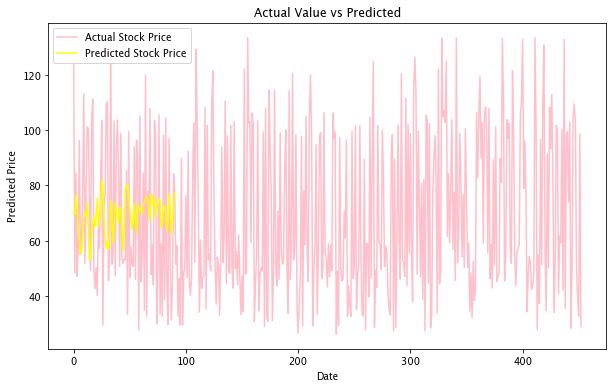

In [87]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

#### As we can tell, this result wasnt great with one feature. I will use more features in the LSTM.

In [88]:
dataset = df[['Open', 'Close','High','Low','ema','ARIMA']]

In [89]:
# Function to create 1D Data into Time series Data
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [91]:
#Libararies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [92]:
np.random.seed(7)

In [93]:
# Import data
dataset = dataset.reindex(index = dataset.index[::-1])

In [94]:
# Create own index for flexibility
obs = np.arange(1, len(dataset) + 1, 1)

In [95]:
# Take different indicators for prediction
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

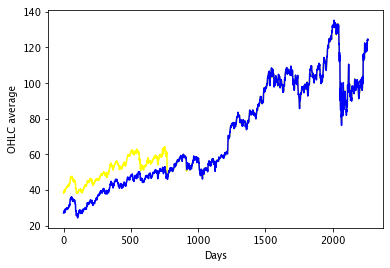

In [96]:
# Plot
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()

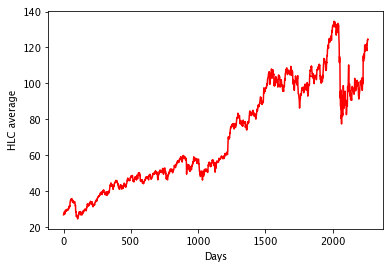

In [97]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()


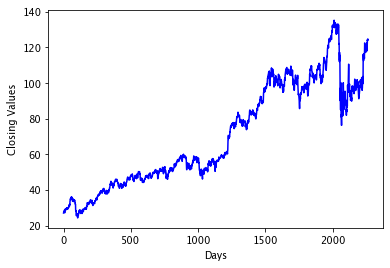

In [98]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [99]:
# Prepare time series data
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [100]:
# Train test split
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [101]:
# Time series Data (for Time t, values for Time T + 1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [102]:
# Reshape and Train and Test Data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [103]:
# LSTM Model
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [105]:
# Compile Model
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1696/1696 - 3s - loss: 0.0158 - mae: 0.1110
Epoch 2/50
1696/1696 - 1s - loss: 0.0134 - mae: 0.1022
Epoch 3/50
1696/1696 - 1s - loss: 0.0116 - mae: 0.0949
Epoch 4/50
1696/1696 - 1s - loss: 0.0101 - mae: 0.0884
Epoch 5/50
1696/1696 - 1s - loss: 0.0088 - mae: 0.0824
Epoch 6/50
1696/1696 - 1s - loss: 0.0076 - mae: 0.0767
Epoch 7/50
1696/1696 - 1s - loss: 0.0066 - mae: 0.0715
Epoch 8/50
1696/1696 - 1s - loss: 0.0058 - mae: 0.0665
Epoch 9/50
1696/1696 - 1s - loss: 0.0050 - mae: 0.0620
Epoch 10/50
1696/1696 - 1s - loss: 0.0043 - mae: 0.0576
Epoch 11/50
1696/1696 - 1s - loss: 0.0038 - mae: 0.0535
Epoch 12/50
1696/1696 - 1s - loss: 0.0032 - mae: 0.0497
Epoch 13/50
1696/1696 - 1s - loss: 0.0028 - mae: 0.0460
Epoch 14/50
1696/1696 - 1s - loss: 0.0024 - mae: 0.0426
Epoch 15/50
1696/1696 - 1s - loss: 0.0021 - mae: 0.0394
Epoch 16/50
1696/1696 - 1s - loss: 0.0018 - mae: 0.0364
Epoch 17/50
1696/1696 - 1s - loss: 0.0015 - mae: 0.0336
Epoch 18/50
1696/1696 - 1s - loss: 0.0013 - mae: 0.0311
E

In [106]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)


36/36 [==============================] - 1s 750us/step - loss: 8.6680e-05 - mae: 0.0077
Mean Absolute Error for Y: [8.668037480674684e-05, 0.0077492850832641125]


#### The mean absolute error is lower than the past model with one feature. The errror is almost 0.0077 as compared to 0.21. So the training model should be pretty close to testing model.

In [107]:
# Prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [108]:
# De-normalize for plotting
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [109]:
# Train RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 1.29


In [111]:
# Test RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 0.90


In [112]:
# Create Similar Dataset to Plot
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [113]:
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

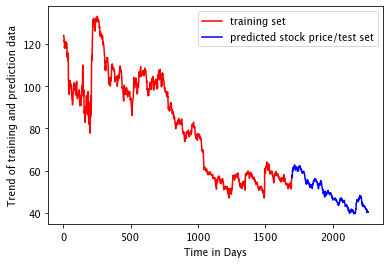

In [114]:
# Plot of main Open High Low CLose values
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

#### Trained our data for the first 1800 days or so and then tested for test. The prediction plot has kept up with the trend and doesnt look too bad.

In [115]:
# Predict future values
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 40.30082702636719
Next Day Value: 39.747711181640625


<ipython-input-115-07399bf6cb21>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-115-07399bf6cb21>:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))


#### The value was found relying on OHLC values. Before i was getting a value that was 20 dollars lower for next day value so I am happy with this. Although this is not indicative of the true JP Morgan stock price becuase it actually went in the opposite direction. In the next notebook I will focus more on normalization with Hyperparameter tuning and less on feature extraction. 

#### LSTM doesnt do a good job at predicting day to day values.

# Conclusions

#### 1.) Features:

#### Focused on feature engineering and made a total of 18 features. 

#### 2.) ARIMA Model

#### We got a great ARIMA model but werent able to use it in LSTM

#### 3.) Fourier Transform Model

#### We got great predictions with Fouerier Transform that were very close to actual values

#### 4.) LSTM with One Feature

#### Not a good model

#### 5.) LSTM with Multiple Features

#### An ok model but not what we wanted, maybe LSTM is not good at predicting stock price directly.